##  Importing Dependencies
   We shall start by importing all the neccessary libraries. I will explain the exact use of each library later in this notebook.

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Bidirectional, SpatialDropout1D, Dense, Embedding, Input, Conv1D, GlobalMaxPool1D, Dropout, concatenate, Layer, InputSpec, CuDNNLSTM, LSTM
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, regularizers, constraints
from keras.utils.conv_utils import conv_output_length
from tensorflow.keras.regularizers import l2
from keras.constraints import maxnorm
from tensorflow.keras.models import Model, Sequential

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [2]:
df = pd.read_csv('data/training.1600000.processed.noemoticon.csv',
                 encoding="ISO-8859-1",
                names=["target", "ids", "date", "flag", "user", "text"])
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
print(f'Number of rows are present in the dataset = {df.shape[0]}')
print(f'Number of columns are present in the dataset = {df.shape[1]}')

Number of rows are present in the dataset = 1600000
Number of columns are present in the dataset = 6


In [4]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [5]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
df['target'] = df['target'].map(decode_map)

In [6]:
temp = df.groupby('target').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,target,text
0,NEGATIVE,800000
1,POSITIVE,800000


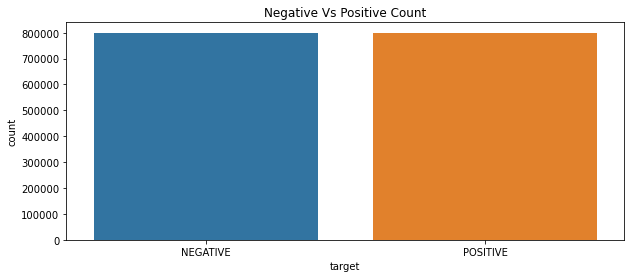

In [7]:
plt.figure(figsize=(10, 4))
plt.title('Negative Vs Positive Count')
sns.countplot(x='target', data=df)
plt.show()

#  Dataset Preprocessing

In [8]:
df['len'] = df['text'].apply(len)
before_total_words = df['len'].sum()
before_total_words

118544178

In [9]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    text = remove_url(text)
    text = remove_emoji(text)
    text = remove_html(text)
    
    return text

In [10]:
df['cleaned_text'] = df['text'].apply(clean_text)
df.head()

,target,ids,date,flag,user,text,len,cleaned_text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,switchfoot awww thats a bummer you shoulda ...
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,111,is upset that he cant update his facebook by t...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,89,kenichan i dived many times for the ball manag...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,47,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",111,nationwideclass no its not behaving at all im ...


In [11]:
df['cleaned_len'] = df['cleaned_text'].apply(len)
after_total_words = df['cleaned_len'].sum()
after_total_words

108852687

In [12]:
print(f'total words reduced after basic removal = {before_total_words - after_total_words}')

total words reduced after basic removal = 9691491


In [13]:
def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [14]:
df['cleaned_text'] = df['cleaned_text'].apply(text_process)
df.head()

,target,ids,date,flag,user,text,len,cleaned_text,cleaned_len
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,switchfoot awww thats bummer shoulda got david...,84
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,111,upset cant update facebook texting might cry r...,105
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,89,kenichan dived many times ball managed save re...,84
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,47,whole body feels itchy like fire,47
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",111,nationwideclass behaving mad cant see,102


In [15]:
df['cleaned_len'] = df['cleaned_text'].apply(len)
after_total_words = df['cleaned_len'].sum()
after_total_words

74977205

In [16]:
print(f'total words reduced after stop words removal = {before_total_words - after_total_words}')

total words reduced after stop words removal = 43566973


In [17]:
df['temp_list'] = df['cleaned_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,good,89380
1,day,82355
2,get,81474
3,like,77721
4,go,72892
5,today,64596
6,going,64079
7,love,63433
8,work,62833
9,cant,62586


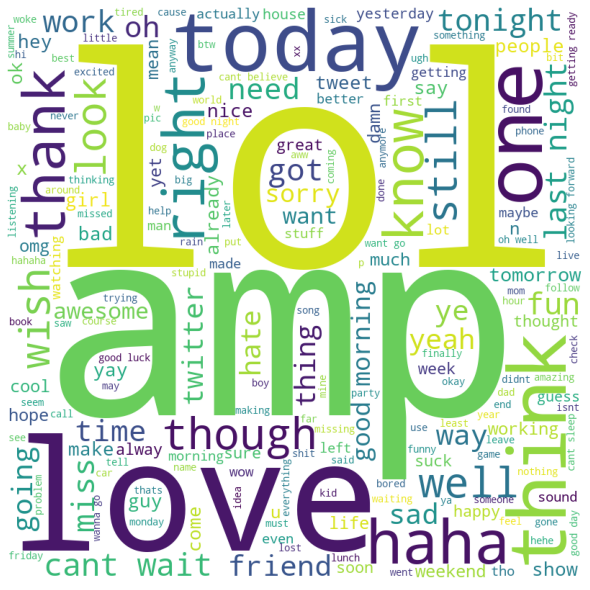

In [18]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10)

full_text = ' '.join(text for text in df['cleaned_text'])
wordcloud.generate(full_text)

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [19]:
temp_list = df[df['target'] != 'NEGATIVE']['cleaned_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in temp_list for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,60832
1,love,46815
2,day,44356
3,like,37095
4,get,36162
5,thanks,33721
6,lol,33463
7,going,30641
8,time,29331
9,today,28406


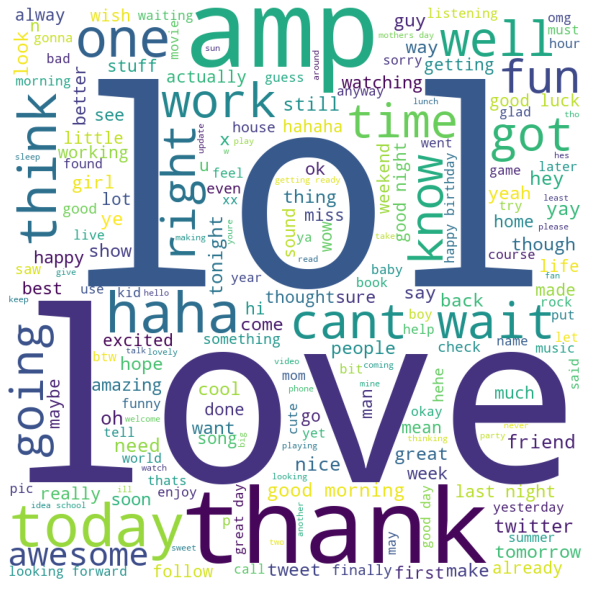

In [20]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10)

full_text = ' '.join(' '.join(line) for line in temp_list.values)
wordcloud.generate(full_text)

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [21]:
temp_list = df[df['target'] == 'NEGATIVE']['cleaned_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in temp_list for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Reds')

,Common_words,count
0,get,45312
1,go,45115
2,work,44053
3,cant,43584
4,like,40626
5,day,37999
6,today,36190
7,going,33438
8,got,32981
9,back,32512


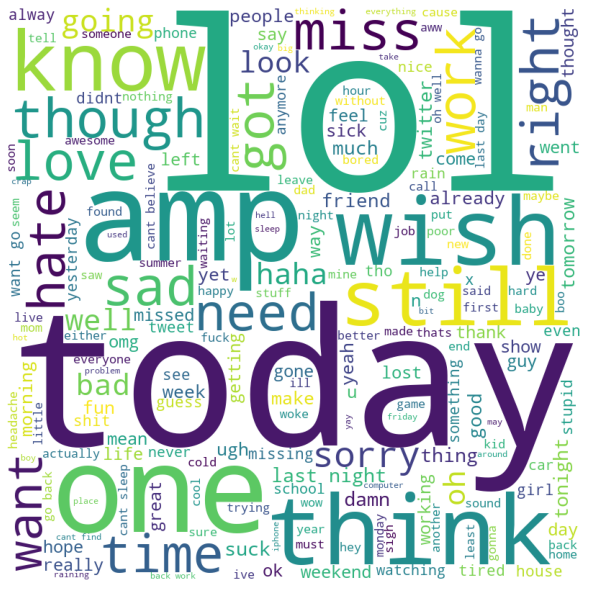

In [22]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10)

full_text = ' '.join(' '.join(line) for line in temp_list.values)
wordcloud.generate(full_text)

# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [23]:
lemmatizer = WordNetLemmatizer()

def lematizer(text):    
    return lemmatizer.lemmatize(text)


df['cleaned_text'] = df['cleaned_text'].apply(lematizer)
df.head()

,target,ids,date,flag,user,text,len,cleaned_text,cleaned_len,temp_list
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,switchfoot awww thats bummer shoulda got david...,61,"[switchfoot, awww, thats, bummer, shoulda, got..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,111,upset cant update facebook texting might cry r...,74,"[upset, cant, update, facebook, texting, might..."
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,89,kenichan dived many times ball managed save re...,58,"[kenichan, dived, many, times, ball, managed, ..."
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,47,whole body feels itchy like fire,32,"[whole, body, feels, itchy, like, fire]"
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",111,nationwideclass behaving mad cant see,37,"[nationwideclass, behaving, mad, cant, see]"


In [24]:
df = df.loc[:, ['target', 'cleaned_text']]

## Train and Test Split

In [86]:
X = df['cleaned_text']
y = df['target']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Calculate the length of our vocabulary

In [43]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer


word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

word_index = word_tokenizer.word_index
vocab_length = len(word_tokenizer.word_index) + 1

NameError: name 'vocab_size' is not defined

In [38]:
print("Vocabulary Size :", vocab_length)

Vocabulary Size : 602462


In [89]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [92]:
X_train = pad_sequences(word_tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)

X_test = pad_sequences(word_tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)


NameError: name 'x_train' is not defined

In [93]:
print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [104]:
y_train = np.where(y_train=='NEGATIVE', 0, 1)
y_test = np.where(y_test=='NEGATIVE', 0, 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

## Word Embeddings

In [29]:
GLOVE_EMB = r'Embedding/glove.6B.300d.txt'
MODEL_PATH = 'model/best_model.hdf5'

EMBEDDING_DIM = 300
BATCH_SIZE = 1024
EPOCHS = 10

In [33]:
embeddingsMaper = {}

with open(GLOVE_EMB, encoding="utf8") as f:
    for line in f.readlines():
        values = line.split()
        word = value = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddingsMaper[word] = coefs

print(f'Found {len(embeddingsMaper)} word vectors.')

Found 400000 word vectors.


In [95]:
embeddingMatrix = np.zeros((vocab_length, EMBEDDING_DIM))

for word, i in word_index.items():
    embeddingVec = embeddingsMaper.get(word)
    if embeddingVec is not None:
        embeddingMatrix[i] = embeddingVec

In [96]:
embeddingLayer = Embedding(vocab_length,
                          EMBEDDING_DIM,
                          weights=[embeddingMatrix],
                          input_length=MAX_SEQUENCE_LENGTH,
                          trainable=False)

# Model Training - LSTM
We are clear to build our Deep Learning model. While developing a DL model, we should keep in mind of key things like Model Architecture, Hyperparmeter Tuning and Performance of the model.

As you can see in the word cloud, the some words are predominantly feature in both Positive and Negative tweets. This could be a problem if we are using a Machine Learning model like Naive Bayes, SVD, etc.. That's why we use **Sequence Models**.

### Sequence Model
![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

Reccurent Neural Networks can handle a seqence of data and learn a pattern of input seqence to give either sequence or scalar value as output. In our case, the Neural Network outputs a scalar value prediction. 

For model architecture, we use

1) **Embedding Layer** - Generates Embedding Vector for each input sequence.

2) **Conv1D Layer** - Its using to convolve data into smaller feature vectors. 

3) **LSTM** - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) **Dense** - Fully Connected Layers for classification


In [146]:
weight_path="model/early_weights.hdf5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=20)
lr = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)
callbacks = [checkpoint, early_stopping, lr]

In [142]:
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH, )))
model.add(embeddingLayer)

model.add(Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1))))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))
adam = Adam(learning_rate=0.01)

model.compile(
    loss='binary_crossentropy', 
    optimizer=adam, 
    metrics=['accuracy']
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 300)           180738600 
                                                                 
 bidirectional_29 (Bidirecti  (None, 30, 128)          186880    
 onal)                                                           
                                                                 
 dropout_47 (Dropout)        (None, 30, 128)           0         
                                                                 
 bidirectional_30 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dropout_48 (Dropout)        (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 64)               

In [147]:
history = model.fit(X_train, y_train, batch_size=1024, epochs=100,
                    validation_data=(X_test, y_test), callbacks=callbacks, 
                   verbose=1)

Epoch 1/100
1250/1250 [==============================] - ETA: 0s - loss: 0.4062 - accuracy: 0.8130
Epoch 1: val_loss improved from inf to 0.45285, saving model to model\early_weights.hdf5
1250/1250 [==============================] - 36s 29ms/step - loss: 0.4062 - accuracy: 0.8130 - val_loss: 0.4528 - val_accuracy: 0.7893 - lr: 0.0100
Epoch 2/100
1250/1250 [==============================] - ETA: 0s - loss: 0.4061 - accuracy: 0.8133
Epoch 2: val_loss improved from 0.45285 to 0.44984, saving model to model\early_weights.hdf5
1250/1250 [==============================] - 38s 31ms/step - loss: 0.4061 - accuracy: 0.8133 - val_loss: 0.4498 - val_accuracy: 0.7881 - lr: 0.0100
Epoch 3/100
1248/1250 [============================>.] - ETA: 0s - loss: 0.4061 - accuracy: 0.8133
Epoch 3: val_loss did not improve from 0.44984
1250/1250 [==============================] - 31s 25ms/step - loss: 0.4061 - accuracy: 0.8133 - val_loss: 0.4536 - val_accuracy: 0.7890 - lr: 0.0100
Epoch 4/100
1249/1250 [=======

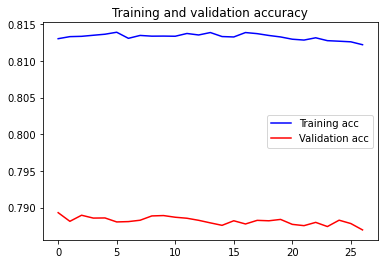

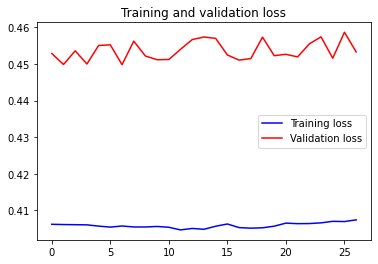

In [184]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [171]:
SENTIMENT_THRESHOLDS = (0.4, 0.7)

In [175]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = 'NEGATIVE'
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = 'POSITIVE'

        return label
    else:
        return 'NEGATIVE' if score < 0.5 else 'POSITIVE'

In [176]:
import time


def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(word_tokenizer.texts_to_sequences([text]), maxlen=30)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [177]:
predict("I love the music")

1/1 [==============================] - 0s 24ms/step


{'label': 'POSITIVE',
 'score': 0.950571596622467,
 'elapsed_time': 0.07500004768371582}

In [178]:
predict("I hate the rain")

1/1 [==============================] - 0s 25ms/step


{'label': 'NEGATIVE',
 'score': 0.010707204230129719,
 'elapsed_time': 0.05900120735168457}

In [179]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 27ms/step


{'label': 'NEUTRAL',
 'score': 0.580411970615387,
 'elapsed_time': 0.062001943588256836}

### Confusion Matrix

In [148]:
y_proba = model.predict(X_test)
y_pred = np.where(y_proba >= 0.5, 1, 0).flatten()
y_pred

10000/10000 [==============================] - 115s 11ms/step


array([0, 1, 1, ..., 1, 0, 0])

In [155]:
import itertools


def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

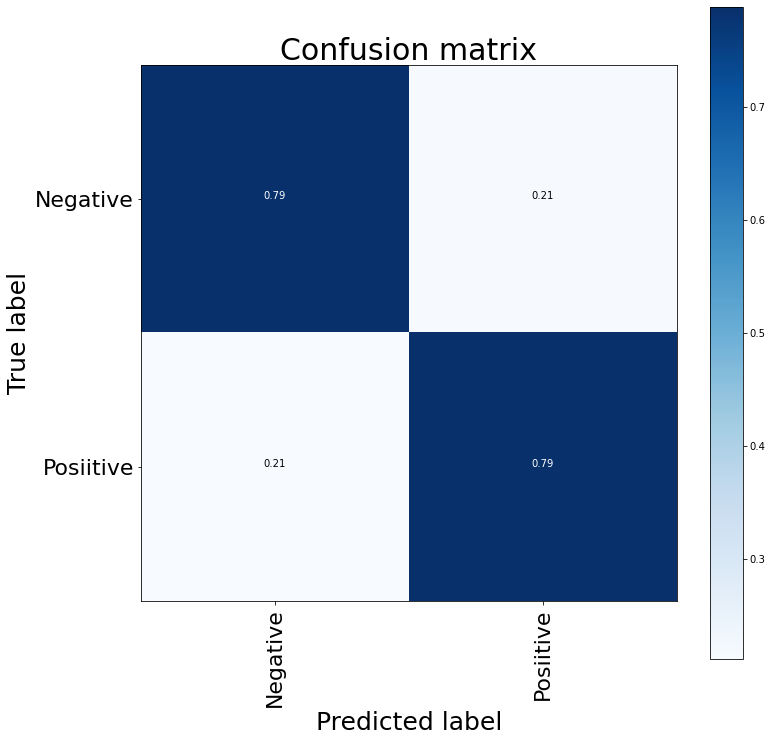

Wall time: 376 ms


In [156]:
%%time

cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Posiitive'], title="Confusion matrix")
plt.show()

In [157]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79    159494
           1       0.79      0.79      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



### Save model

In [185]:
model.save('model.h5')

In [188]:
import joblib

joblib.dump(word_tokenizer, 'model/word_tokenizer.h5')

['model/word_tokenizer.h5']